#Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC
import keras
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import itertools
import matplotlib.pyplot as plt

SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#uploading local dataset (CSV File)
from google.colab import files
uploaded = files.upload()

Saving Olympic Athletes Dataset.csv to Olympic Athletes Dataset.csv


In [3]:
#From CSV file
csvFile = "Olympic Athletes Dataset.csv"
csvdata = pd.read_csv(csvFile)
csvdata.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


##Extracting Raw Data

In [4]:
#Extracting the columns we want
csvraw = pd.DataFrame(csvdata[["Sex","Age","Height","Weight","Team","Sport","Medal"]])
csvraw.head()

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,24.0,180.0,80.0,China,Basketball,NaN
1,M,23.0,170.0,60.0,China,Judo,NaN
2,M,24.0,NaN,NaN,Denmark,Football,NaN
3,M,34.0,NaN,NaN,Denmark/Sweden,Tug-Of-War,Gold
4,F,21.0,185.0,82.0,Netherlands,Speed Skating,NaN


##Cleaning Up and Preparation of Data

In [5]:
#replcaing all types of medals: Bronze, Silver and Gold as 1
csvraw["Medal"] = csvraw["Medal"].map({'Bronze':"Y", 'Silver':"Y",'Gold':"Y"})

#replacing all NaN rows for medals as 0
csvraw["Medal"] = csvraw.Medal.fillna("N")

csvraw #to check

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,24.0,180.0,80.0,China,Basketball,N
1,M,23.0,170.0,60.0,China,Judo,N
2,M,24.0,NaN,NaN,Denmark,Football,N
3,M,34.0,NaN,NaN,Denmark/Sweden,Tug-Of-War,Y
4,F,21.0,185.0,82.0,Netherlands,Speed Skating,N
...,...,...,...,...,...,...,...
271111,M,29.0,179.0,89.0,Poland-1,Luge,N
271112,M,27.0,176.0,59.0,Poland,Ski Jumping,N
271113,M,27.0,176.0,59.0,Poland,Ski Jumping,N
271114,M,30.0,185.0,96.0,Poland,Bobsleigh,N


In [6]:
#check if there is a need to remove empty cells
csvraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sex     271116 non-null  object 
 1   Age     261642 non-null  float64
 2   Height  210945 non-null  float64
 3   Weight  208241 non-null  float64
 4   Team    271116 non-null  object 
 5   Sport   271116 non-null  object 
 6   Medal   271116 non-null  object 
dtypes: float64(3), object(4)
memory usage: 14.5+ MB


In [7]:
#removing all the rows with empty cells
csvData=csvraw.dropna()
csvData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206165 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sex     206165 non-null  object 
 1   Age     206165 non-null  float64
 2   Height  206165 non-null  float64
 3   Weight  206165 non-null  float64
 4   Team    206165 non-null  object 
 5   Sport   206165 non-null  object 
 6   Medal   206165 non-null  object 
dtypes: float64(3), object(4)
memory usage: 12.6+ MB


In [8]:
csvData[["Medal"]] = csvData[["Medal"]].astype('category') #changing the object type
csvData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206165 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   Sex     206165 non-null  object  
 1   Age     206165 non-null  float64 
 2   Height  206165 non-null  float64 
 3   Weight  206165 non-null  float64 
 4   Team    206165 non-null  object  
 5   Sport   206165 non-null  object  
 6   Medal   206165 non-null  category
dtypes: category(1), float64(3), object(3)
memory usage: 11.2+ MB


count     206165
unique         2
top            N
freq      175984
Name: Medal, dtype: object


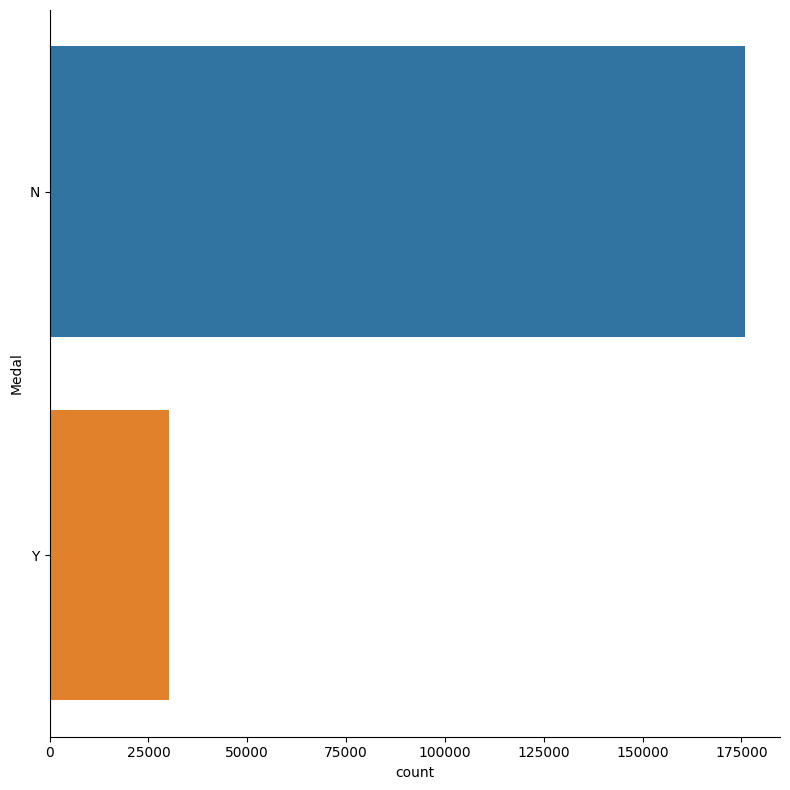

In [9]:
#evaluating the difference between the two medal classes
print (csvData['Medal'].describe())
sb.catplot(y = 'Medal', data = csvData, kind = "count", height = 8)

##Evening out Y and N classes

In [10]:
# extracting only male that take part in swimming with medals
datamedals = csvData[(csvData.Medal == "Y")&(csvData.Sex == "M")&(csvData.Sport == "Swimming")]
datamedals

,Sex,Age,Height,Weight,Team,Sport,Medal
803,M,22.0,190.0,78.0,Soviet Union,Swimming,Y
804,M,22.0,190.0,78.0,Soviet Union,Swimming,Y
814,M,30.0,197.0,92.0,Australia,Swimming,Y
892,M,21.0,175.0,64.0,Great Britain,Swimming,Y
1843,M,19.0,198.0,100.0,United States,Swimming,Y
...,...,...,...,...,...,...,...
269783,M,29.0,208.0,93.0,Germany,Swimming,Y
270394,M,21.0,193.0,86.0,United States,Swimming,Y
270732,M,23.0,186.0,83.0,Netherlands,Swimming,Y
270773,M,20.0,193.0,82.0,Soviet Union,Swimming,Y


In [11]:
#choosing the team with the most number of medals won in swimming
n=1
datamedals.value_counts(["Team"])[:n].index.tolist()

[('United States',)]

In [12]:
#extract data from US, South Korea and China
cleanData = csvData[(csvData.Sex == "M")&((csvData.Team == "United States")|(csvData.Team == "Singapore") |(csvData.Team == "South Korea")|(csvData.Team == "China"))
                    &(csvData.Sport == "Swimming")]
cleanData = cleanData.reset_index() #reset indexes
cleanData = cleanData.drop(['index'], axis = 1)
cleanData

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,19.0,198.0,100.0,United States,Swimming,Y
1,M,23.0,198.0,100.0,United States,Swimming,Y
2,M,23.0,198.0,100.0,United States,Swimming,Y
3,M,23.0,198.0,100.0,United States,Swimming,Y
4,M,27.0,198.0,100.0,United States,Swimming,Y
...,...,...,...,...,...,...,...
1046,M,22.0,177.0,85.0,China,Swimming,N
1047,M,22.0,177.0,85.0,China,Swimming,N
1048,M,21.0,193.0,86.0,United States,Swimming,N
1049,M,21.0,193.0,86.0,United States,Swimming,Y


In [13]:
#validate if no. of Y and N class are similar
cleanData ['Medal'].value_counts()

N    527
Y    524
Name: Medal, dtype: int64

#Machine Learning Method 1: Binary Classification

There are a total of 1051 rows. The training and test set will carry 80% to 20% of the data respectively. Therefore, the training data will have 841 rows and the test data will have 210 rows.

In [14]:
cleandata_medal = pd.DataFrame(cleanData['Medal'])
cleandata_num = pd.DataFrame(cleanData[['Age','Weight','Height']])

testSize = 0.2

##Calculation of Classification Accuracy and Confusion Matrix for Age

In [15]:
cleandata_age = pd.DataFrame(cleandata_num['Age'])
age_train, age_test, medal_train, medal_test = train_test_split(cleandata_age, cleandata_medal,
                                                                test_size = testSize,
                                                                random_state=SEED)

In [16]:
from sklearn.tree import DecisionTreeClassifier
dectree = DecisionTreeClassifier()
dectree.fit(age_train, medal_train)

DecisionTreeClassifier()

In [17]:
#To retrieve the max depth of the tree
tree_depth = dectree.get_depth()
#To retrieve the max number of leaves (leaves refer to edge nodes with no children below it)
tree_number_leaves = dectree.get_n_leaves()
print('Tree depth:', tree_depth)
print('Tree number of leaves:', tree_number_leaves)

Tree depth: 7
Tree number of leaves: 18


###Checking Predictions on Train Set

Accuracy  	: 0.5880952380952381
Precision 	: 0.598404255319149
Recall    	: 0.5357142857142857


<Axes: >

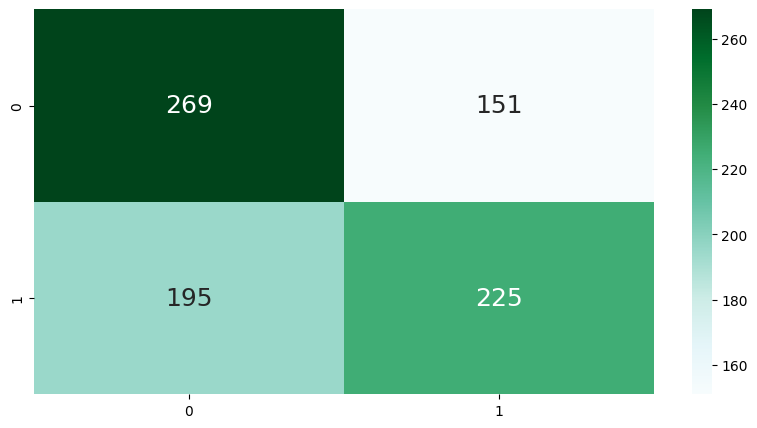

In [18]:
#Predict the Response corresponding to Predictors
medal_train_pred = dectree.predict(age_train)

print("Accuracy  \t:", dectree.score(age_train, medal_train))
print("Precision \t:", precision_score(medal_train, medal_train_pred, pos_label="Y"))
print("Recall    \t:", recall_score(medal_train, medal_train_pred, pos_label="Y"))

#Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
f = plt.subplots(figsize=(10, 5))

#confusion_matric(true, pred) - heatmap y-axis is true, x-axis is predicted
sb.heatmap(confusion_matrix(medal_train, medal_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, cmap = "BuGn")
#1 stand for Y class and 0 stands for N class in medals, y-axis is actual, x-axis is predicted



###Checking Predictions on Test Set

Accuracy  	: 0.5734597156398105
Precision 	: 0.5777777777777777
Recall    	: 0.5


<Axes: >

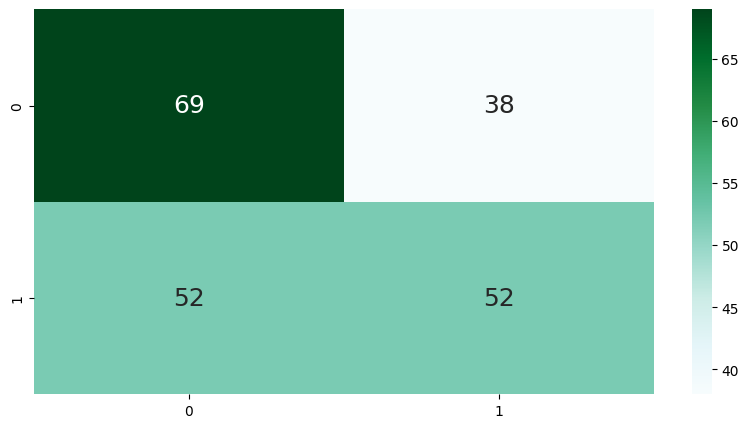

In [19]:
#Predict the Response corresponding to Predictors
medal_test_pred = dectree.predict(age_test)

#Print the Classification Accuracy
print("Accuracy  \t:", dectree.score(age_test, medal_test))
print("Precision \t:", precision_score(medal_test, medal_test_pred, pos_label="Y"))
print("Recall    \t:", recall_score(medal_test, medal_test_pred, pos_label="Y"))

#Plot the two-way Confusion Matrix
f = plt.subplots(figsize=(10, 5))

#confusion_matrix(true, pred) - heatmap y-axis is true, x-axis is predicted
sb.heatmap(confusion_matrix(medal_test, medal_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, cmap = "BuGn")
#1 stands for Y class and 0 stands for N class in medals, y-axis is actual, x-axis is predicted

###Storing the results in a list

In [20]:
# store values for comparison later, to STORE THE VALUES IN A LIST by using .append
Score_Tables = list() #create a new empty list

# Temp variables to store al the 3 values per scenario
Temp = ['Age(Train)', round(dectree.score(age_train, medal_train), 2),
        round(precision_score(medal_train, medal_train_pred, pos_label="Y"), 2),
        round(recall_score(medal_train, medal_train_pred, pos_label="Y"), 2),
        tree_depth, tree_number_leaves]
Score_Tables.append(Temp) #add into the empty list each time

Temp2 = ['Age(Test)', round(dectree.score(age_test, medal_test), 2),
        round(precision_score(medal_test, medal_test_pred, pos_label="Y"), 2),
        round(recall_score(medal_test, medal_test_pred, pos_label="Y"), 2),
         tree_depth, tree_number_leaves]
Score_Tables.append(Temp2) #add into the empty list each time

Score_Tables

[['Age(Train)', 0.59, 0.6, 0.54, 7, 18], ['Age(Test)', 0.57, 0.58, 0.5, 7, 18]]

##Calculation of Classification Accuracy and Confusion Matrix for Height

Goodness of Fit of Model 	Train Dataset
Accuracy  	: 0.6785714285714286
Precision 	: 0.6651982378854625
Recall    	: 0.719047619047619

Goodness of Fit of Model 	Test Dataset
Accuracy  	: 0.7393364928909952
Precision 	: 0.7425742574257426
Recall    	: 0.7211538461538461



<Axes: >

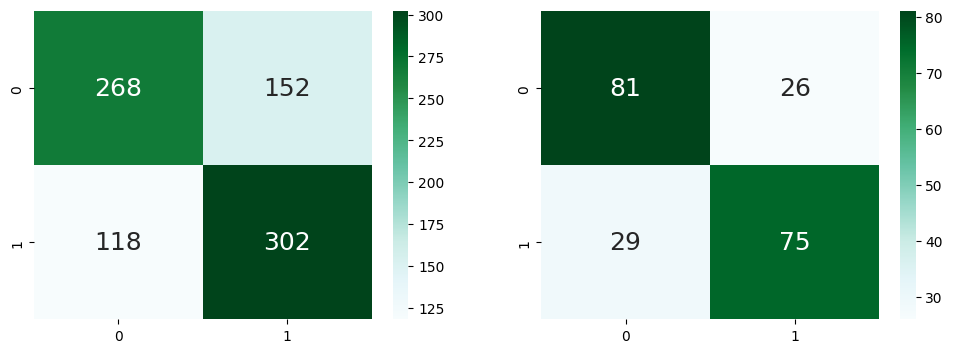

In [21]:
cleandata_height = pd.DataFrame(cleandata_num['Height'])
height_train, height_test, medal_train, medal_test = train_test_split(cleandata_height,
                                                                      cleandata_medal,
                                                                      test_size=testSize,
                                                                      random_state=SEED)

dectree = DecisionTreeClassifier()
dectree.fit(height_train, medal_train)

medal_train_pred = dectree.predict(height_train)
medal_test_pred = dectree.predict(height_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Accuracy  \t:", dectree.score(height_train, medal_train))
print("Precision \t:", precision_score(medal_train, medal_train_pred, pos_label="Y"))
print("Recall    \t:", recall_score(medal_train, medal_train_pred, pos_label="Y"))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Accuracy  \t:", dectree.score(height_test, medal_test))
print("Precision \t:", precision_score(medal_test, medal_test_pred, pos_label="Y"))
print("Recall    \t:", recall_score(medal_test, medal_test_pred, pos_label="Y"))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(medal_train, medal_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "BuGn")
sb.heatmap(confusion_matrix(medal_test, medal_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "BuGn")

In [22]:
tree_depth = dectree.get_depth()
tree_number_leaves = dectree.get_n_leaves()
print('Tree depth:',tree_depth)
print('Tree number of leaves:',tree_number_leaves)

Tree depth: 10
Tree number of leaves: 31


In [23]:
Temp = ['Height(Train)', round(dectree.score(height_train, medal_train), 2),
        round(precision_score(medal_train, medal_train_pred, pos_label="Y"), 2),
        round(recall_score(medal_train, medal_train_pred, pos_label="Y"), 2),
        tree_depth, tree_number_leaves]
Score_Tables.append(Temp) #add into the empty list each time

Temp2 = ['Height(Test)', round(dectree.score(height_test, medal_test), 2),
        round(precision_score(medal_test, medal_test_pred, pos_label="Y"), 2),
        round(recall_score(medal_test, medal_test_pred, pos_label="Y"), 2),
         tree_depth, tree_number_leaves]
Score_Tables.append(Temp2) #add into the empty list each time

Score_Tables

[['Age(Train)', 0.59, 0.6, 0.54, 7, 18],
 ['Age(Test)', 0.57, 0.58, 0.5, 7, 18],
 ['Height(Train)', 0.68, 0.67, 0.72, 10, 31],
 ['Height(Test)', 0.74, 0.74, 0.72, 10, 31]]

##Calculation of Classification Accuracy and Confusion Matrix for Weight

Goodness of Fit of Model 	Train Dataset
Accuracy  	: 0.6845238095238095
Precision 	: 0.6952141057934509
Recall    	: 0.6571428571428571

Goodness of Fit of Model 	Test Dataset
Accuracy  	: 0.6492890995260664
Precision 	: 0.6704545454545454
Recall    	: 0.5673076923076923



<Axes: >

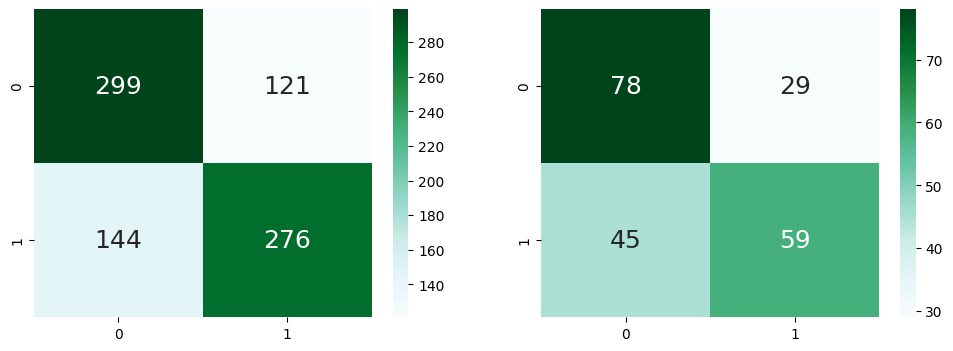

In [24]:
cleandata_weight = pd.DataFrame(cleandata_num['Weight'])
weight_train, weight_test, medal_train, medal_test = train_test_split(cleandata_weight,
                                                                      cleandata_medal,
                                                                      test_size=testSize,
                                                                      random_state=SEED)

dectree = DecisionTreeClassifier()
dectree.fit(weight_train, medal_train)

medal_train_pred = dectree.predict(weight_train)
medal_test_pred = dectree.predict(weight_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Accuracy  \t:", dectree.score(weight_train, medal_train))
print("Precision \t:", precision_score(medal_train, medal_train_pred, pos_label="Y"))
print("Recall    \t:", recall_score(medal_train, medal_train_pred, pos_label="Y"))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Accuracy  \t:", dectree.score(weight_test, medal_test))
print("Precision \t:", precision_score(medal_test, medal_test_pred, pos_label="Y"))
print("Recall    \t:", recall_score(medal_test, medal_test_pred, pos_label="Y"))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(medal_train, medal_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "BuGn")
sb.heatmap(confusion_matrix(medal_test, medal_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "BuGn")

In [25]:
tree_depth = dectree.get_depth()
tree_number_leaves = dectree.get_n_leaves()
print('Tree depth:',tree_depth)
print('Tree number of leaves:',tree_number_leaves)

Tree depth: 8
Tree number of leaves: 35


In [26]:
Temp = ['Weight(Train)', round(dectree.score(weight_train, medal_train), 2),
        round(precision_score(medal_train, medal_train_pred, pos_label="Y"), 2),
        round(recall_score(medal_train, medal_train_pred, pos_label="Y"), 2),
        tree_depth, tree_number_leaves]
Score_Tables.append(Temp) #add into the empty list each time

Temp2 = ['Weight(Test)', round(dectree.score(weight_test, medal_test), 2),
        round(precision_score(medal_test, medal_test_pred, pos_label="Y"), 2),
        round(recall_score(medal_test, medal_test_pred, pos_label="Y"), 2),
         tree_depth, tree_number_leaves]
Score_Tables.append(Temp2) #add into the empty list each time

Score_Tables

[['Age(Train)', 0.59, 0.6, 0.54, 7, 18],
 ['Age(Test)', 0.57, 0.58, 0.5, 7, 18],
 ['Height(Train)', 0.68, 0.67, 0.72, 10, 31],
 ['Height(Test)', 0.74, 0.74, 0.72, 10, 31],
 ['Weight(Train)', 0.68, 0.7, 0.66, 8, 35],
 ['Weight(Test)', 0.65, 0.67, 0.57, 8, 35]]

##MultiVariate Decision Tree

After analysing the data above, I realised that the classification accuracy for the univariate binary tree was always below 70%. Hence, to try to improve the score, a multivariate decision tree was developed instead, using all the 3 numerical variables as predictors.

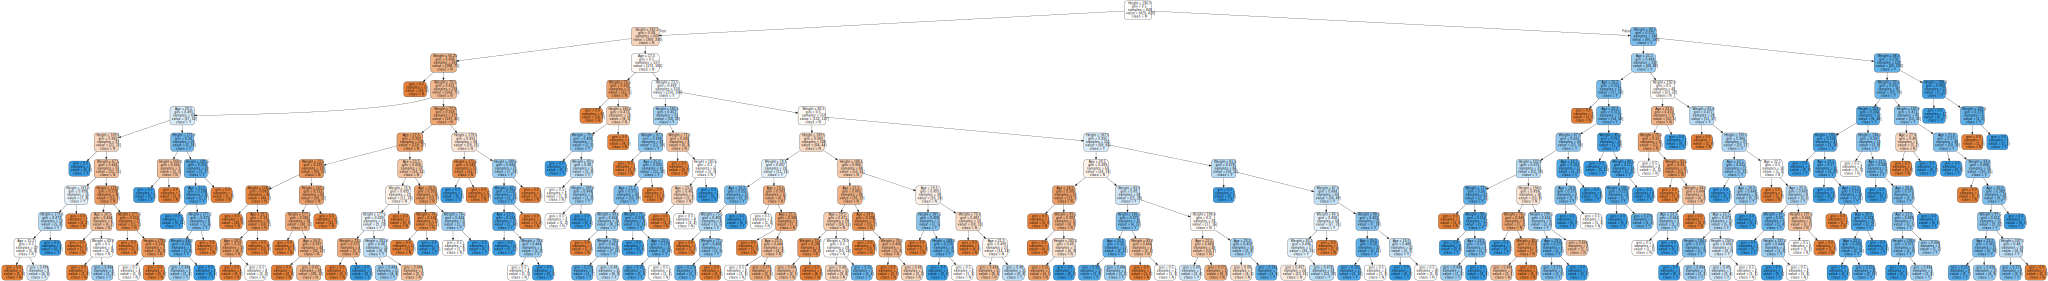

In [27]:
#DISPLAY THE DECISION TREE: we will keep the tree depth to a maximum of 10 so it would hang the computer
x_train, x_test, y_train, y_test = train_test_split(cleandata_num, cleandata_medal,
                                                    test_size = testSize, random_state = SEED)

dectree = DecisionTreeClassifier(max_depth=10)
dectree.fit(x_train, y_train)

# Import export_graphviz from sklearn.tree. to convert trained tree to a graphic tree
from sklearn.tree import export_graphviz

# Export the Decision Tree as a standardize dot object, this is the converison to a graphic tree
treedot = export_graphviz(dectree,
                          feature_names = x_train.columns,
                          out_file = None,
                          filled = True,
                          rounded = True, special_characters = True, class_names=['N', 'Y'])

#Render using graphviz: install graphviz into conda using -conda install python-graphviz
import graphviz
graphviz.Source(treedot) #this is to display the tree

##Calculation of Classification Accuracy and Confusion Matrix for Multi Variate Decision Tree

Goodness of Fit of Model 	Train Dataset
Accuracy  	: 0.8821428571428571
Precision 	: 0.9212598425196851
Recall    	: 0.8357142857142857

Goodness of Fit of Model 	Test Dataset
Accuracy  	: 0.6919431279620853
Precision 	: 0.7294117647058823
Recall    	: 0.5961538461538461



<Axes: >

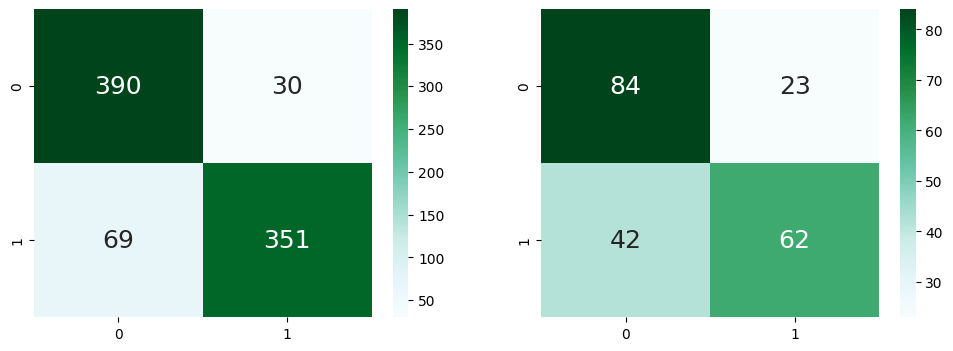

In [28]:
dectree = DecisionTreeClassifier() #max depth

dectree.fit(x_train, y_train)

y_train_pred = dectree.predict(x_train)
y_test_pred = dectree.predict(x_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Accuracy  \t:", dectree.score(x_train, y_train))
print("Precision \t:", precision_score(y_train, y_train_pred, pos_label="Y"))
print("Recall    \t:", recall_score(y_train, y_train_pred, pos_label="Y"))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Accuracy  \t:", dectree.score(x_test, y_test))
print("Precision \t:", precision_score(y_test, y_test_pred, pos_label="Y"))
print("Recall    \t:", recall_score(y_test, y_test_pred, pos_label="Y"))
print()

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "BuGn")
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "BuGn")

In [29]:
tree_depth = dectree.get_depth()
tree_number_leaves = dectree.get_n_leaves()
print('Tree depth:',tree_depth)
print('Tree number of leaves:',tree_number_leaves)

Tree depth: 18
Tree number of leaves: 268


In [30]:
Temp = ['MultiVar(Train)', round(dectree.score(x_train, y_train), 2),
        round(precision_score(y_train, y_train_pred, pos_label="Y"), 2),
        round(recall_score(y_train, y_train_pred, pos_label="Y"), 2),
        tree_depth, tree_number_leaves]
Score_Tables.append(Temp) #add into the empty list each time

Temp2 = ['MultiVar(Test)', round(dectree.score(x_test, y_test), 2),
        round(precision_score(y_test, y_test_pred, pos_label="Y"), 2),
        round(recall_score(y_test, y_test_pred, pos_label="Y"), 2),
         tree_depth, tree_number_leaves]
Score_Tables.append(Temp2) #add into the empty list each time

Score_Tables

[['Age(Train)', 0.59, 0.6, 0.54, 7, 18],
 ['Age(Test)', 0.57, 0.58, 0.5, 7, 18],
 ['Height(Train)', 0.68, 0.67, 0.72, 10, 31],
 ['Height(Test)', 0.74, 0.74, 0.72, 10, 31],
 ['Weight(Train)', 0.68, 0.7, 0.66, 8, 35],
 ['Weight(Test)', 0.65, 0.67, 0.57, 8, 35],
 ['MultiVar(Train)', 0.88, 0.92, 0.84, 18, 268],
 ['MultiVar(Test)', 0.69, 0.73, 0.6, 18, 268]]

The values of the classification accuracy and the confusion matrix ratios have been collated into a list using .append before it is converted to a pd data frame with labelled columns for ease of comparison below.

In [31]:
# display of all scores and values per scenario
# Convert List to DataFrame format in order to display better
Score_DF = pd.DataFrame(Score_Tables)

# Name the columns of the new dataframe
Score_DF.columns = ['Scenario', 'Accuracy', 'Precision', 'Recall', 'Tree Depths','Number of Tree Leaves']

Score_DF

,Scenario,Accuracy,Precision,Recall,Tree Depths,Number of Tree Leaves
0,Age(Train),0.59,0.60,0.54,7,18
1,Age(Test),0.57,0.58,0.50,7,18
2,Height(Train),0.68,0.67,0.72,10,31
3,Height(Test),0.74,0.74,0.72,10,31
4,Weight(Train),0.68,0.70,0.66,8,35
5,Weight(Test),0.65,0.67,0.57,8,35
6,MultiVar(Train),0.88,0.92,0.84,18,268
7,MultiVar(Test),0.69,0.73,0.60,18,268


##Results of Machine Learning - Binary Classification

To avoid the computer from crashing when running the code, a decision tree of depth 10 was plotted. Upon plotting the decision tree, it can be seen that most of the leaf nodes have a Gini Index close to 0, which is ideal as it indicates minimal confusion during classification.

Based on the Score_DF table right in the above cell, comparing the test set for all 3 variables, it is evident that Height (Test) and have a higher accuracy score as compared to Weight (Test) and Age (Test) , which are 0.74, 0.65 and 0.57 respectively. This indicates that physical characteristics are important predictors of medal classes since they affect the chances of athletes attaining a medal. This answers our first question, as physical characteristics do play an important role in identifying potential Olympic medalists.

Also, our second question can also be answered based on the results above. Height would be more crucial, followed by Weight and then Age .

##Predictions on Tokyo 2020 Swimming Event

In [32]:
Tokyo2020 = [['Caeleb Dressel',24,92,191,'Y'], ['Duncan Scott',23,81,190,'Y']
          , ['Bruno Fratus',31,84,187,'Y'], ['Jérémy Desplanches',26,72,189,'Y'], ['Tomoru Honda',19,76,172,'Y']
          , ['Thomas Dean',20,88,194,'Y'],  ['Robert Glință', 23,75,185,'N'], ['Radosław Kawęcki', 29,82,188,'N']
          , ['Maxime Grousset', 21,92,190,'N'], ['Hwang Sun-woo', 17,72,186,'N'], ['Isaac', 16,88,172,'N']]

Tokyo2020df = pd.DataFrame(Tokyo2020)
Tokyo2020df.columns = ['Name','Age','Weight','Height','Medal']
Tokyo2020df

,Name,Age,Weight,Height,Medal
0,Caeleb Dressel,24,92,191,Y
1,Duncan Scott,23,81,190,Y
2,Bruno Fratus,31,84,187,Y
3,Jérémy Desplanches,26,72,189,Y
4,Tomoru Honda,19,76,172,Y
5,Thomas Dean,20,88,194,Y
6,Robert Glință,23,75,185,N
7,Radosław Kawęcki,29,82,188,N
8,Maxime Grousset,21,92,190,N
9,Hwang Sun-woo,17,72,186,N


In [33]:
Tokyo_x_test = pd.DataFrame(Tokyo2020df[["Age","Weight","Height"]])
Tokyo_x_test

,Age,Weight,Height
0,24,92,191
1,23,81,190
2,31,84,187
3,26,72,189
4,19,76,172
5,20,88,194
6,23,75,185
7,29,82,188
8,21,92,190
9,17,72,186


In [34]:
Tokyo_pred_class = dectree.predict(Tokyo_x_test)
Tokyo_pred_class = pd.DataFrame(Tokyo_pred_class)
Tokyo_pred_class.columns = ['Predicted Class']
Tokyo_pred_class

,Predicted Class
0,Y
1,Y
2,N
3,N
4,N
5,Y
6,N
7,N
8,N
9,N


In [35]:
Tokyo2020final = pd.concat([Tokyo2020df, Tokyo_pred_class], axis = 1)
Tokyo2020final

,Name,Age,Weight,Height,Medal,Predicted Class
0,Caeleb Dressel,24,92,191,Y,Y
1,Duncan Scott,23,81,190,Y,Y
2,Bruno Fratus,31,84,187,Y,N
3,Jérémy Desplanches,26,72,189,Y,N
4,Tomoru Honda,19,76,172,Y,N
5,Thomas Dean,20,88,194,Y,Y
6,Robert Glință,23,75,185,N,N
7,Radosław Kawęcki,29,82,188,N,N
8,Maxime Grousset,21,92,190,N,N
9,Hwang Sun-woo,17,72,186,N,N


Goodness of Fit of Model 	Test Dataset
Accuracy  	: 0.6363636363636364
Precision 	: 0.75
Recall    	: 0.5



<Axes: >

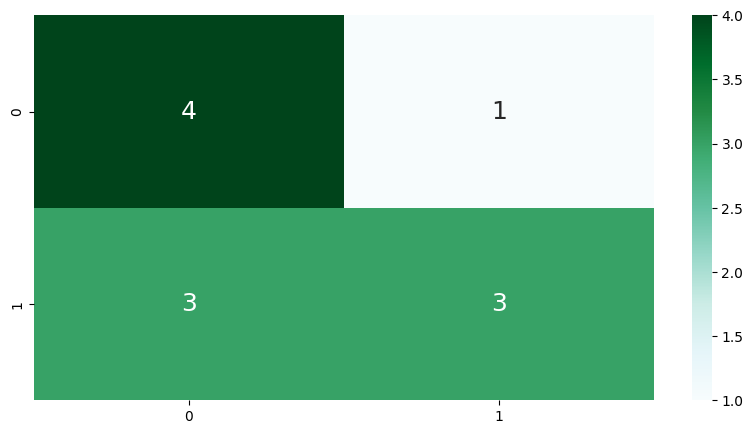

In [36]:
Tokyo_y_test = pd.DataFrame(Tokyo2020df["Medal"])

print("Goodness of Fit of Model \tTest Dataset")
print("Accuracy  \t:", dectree.score(Tokyo_x_test, Tokyo_y_test))
print("Precision \t:", precision_score(Tokyo_y_test, Tokyo_pred_class, pos_label="Y"))
print("Recall    \t:", recall_score(Tokyo_y_test, Tokyo_pred_class, pos_label="Y"))
print()

f = plt.subplots(figsize=(10, 5))
sb.heatmap(confusion_matrix(Tokyo_y_test, Tokyo_pred_class),
           annot = True, fmt=".0f", annot_kws={"size": 18}, cmap = "BuGn")